In [2]:
pip install -i https://test.pypi.org/simple/ safeaipackage==2.0.5

Looking in indexes: https://test.pypi.org/simple/
Note: you may need to restart the kernel to use updated packages.


In [3]:
import luminaire

In [7]:
luminaire.model.base_model.BaseModel()

In [25]:
import pandas as pd
import numpy as np
import warnings
import scipy
import matplotlib.pyplot as plt
import safeaipackage

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 10000)

In [48]:
data = pd.read_excel("D:/files/research_activities/ORGANIZED_FILES/safeaipackage/examples/employee.xlsx")
print("This dataset has {} rows and {} columns".format(data.shape[0], data.shape[1]))
data.head()

This dataset has 473 rows and 9 columns


,salary,age,edu,startsal,jobtime,prevexp,minority,gender,jobcat
0,57000,36,15,27000,98,144,no_min,m,manager
1,40200,30,16,18750,98,36,no_min,m,Clerical
2,21450,59,12,12000,98,381,no_min,f,Clerical
3,21900,41,8,13200,98,190,no_min,f,Clerical
4,45000,33,15,21000,98,138,no_min,m,Clerical


In [49]:
data["gender"] = np.where(data["gender"]=="m", 0, 1)
data["minority"] = np.where(data["minority"]=="no_min", 0, 1)
data = pd.get_dummies(data, columns=["jobcat"])
data.head()

,salary,age,edu,startsal,jobtime,prevexp,minority,gender,jobcat_Clerical,jobcat_Custodial,jobcat_manager
0,57000,36,15,27000,98,144,0,0,0,0,1
1,40200,30,16,18750,98,36,0,0,1,0,0
2,21450,59,12,12000,98,381,0,1,1,0,0
3,21900,41,8,13200,98,190,0,1,1,0,0
4,45000,33,15,21000,98,138,0,0,1,0,0


In [50]:
data["salary_growth"] = data["salary"]-data["startsal"]

data.drop(["salary", "startsal"], axis=1, inplace=True)
data.head()

,age,edu,jobtime,prevexp,minority,gender,jobcat_Clerical,jobcat_Custodial,jobcat_manager,salary_growth,doubling_salary
0,36,15,98,144,0,0,0,0,1,30000,1
1,30,16,98,36,0,0,1,0,0,21450,1
2,59,12,98,381,0,1,1,0,0,9450,0
3,41,8,98,190,0,1,1,0,0,8700,0
4,33,15,98,138,0,0,1,0,0,24000,1


In [62]:
X = data.drop(["salary_growth", "doubling_salary"], axis=1)
y_reg = data["salary_growth"]
y_clas = data["doubling_salary"]

xtrain_reg, xtest_reg, ytrain_reg, ytest_reg = train_test_split(X, y_reg, test_size=0.3, random_state=1)
xtrain_clas, xtest_clas, ytrain_clas, ytest_clas = train_test_split(X, y_clas, test_size=0.3, random_state=1)

print(xtrain_reg.shape)
print(xtrain_clas.shape)

(331, 9)
(331, 9)


In [63]:
ann_full = MLPRegressor(random_state=1).fit(xtrain_reg, ytrain_reg)

ann_predictions_full = ann_full.predict(xtest_reg)
ann_predictions_full

array([ 3953.9401448 ,  2649.5728026 ,  5670.15745654,  2652.09287437,
        2639.15008448,  2473.63287694,  5814.9851976 ,  3456.35684027,
        3222.19515467,  6067.69857788,  2556.8146545 ,  3198.40595931,
        2598.30220343, 11024.54892796,  2855.97454025,  8094.00262865,
        2681.46386069,  3484.34115342,  2189.16762331,  3212.47175565,
        2616.31784594,  3578.2573465 ,  8363.05761723,  5986.12407982,
        6164.56654738,  6210.03723025,  2532.27138063,  5851.18520695,
        2670.90466419,  3614.97556115,  2700.07969269,  2412.77851204,
        4659.20730621,  8661.68978784,  3120.05559088,  2586.61232513,
        8684.1935276 , 10710.22886449,  2803.70575483,  4465.38451791,
        2655.15364948,  3597.72227381,  3674.58615885,  2939.12365787,
        4564.293529  ,  4585.11836207, 11368.53608657,  2828.67862207,
        3638.06802452,  3176.40253847,  3530.49489338,  2967.10939425,
        3234.81811061,  2365.84932451,  9321.64597015,  3166.69229478,
      

In [53]:
rf_model_full = RandomForestClassifier(random_state=1).fit(xtrain_clas, ytrain_clas)

rf_predictions_full = rf_model_full.predict(xtest_clas)
rf_predictions_full

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0])

In [67]:
rf_model_full = RandomForestClassifier(random_state=1).fit(xtrain_clas, ytrain_clas)

rf_predictions_full = [x[1] for x in rf_model_full.predict_proba(xtest_clas)]
rf_predictions_full

[0.51,
 0.79,
 0.78,
 0.63,
 0.92,
 0.9108333333333333,
 0.14,
 0.23,
 0.63,
 0.12,
 0.86,
 0.45,
 0.6,
 0.44,
 0.75,
 0.8,
 0.86,
 0.1,
 0.30360714285714274,
 0.47,
 0.58,
 0.54,
 0.19,
 0.43,
 0.12,
 0.07,
 0.5,
 0.1,
 0.59,
 0.98,
 0.98,
 0.44,
 0.31,
 0.02,
 0.88,
 0.69,
 0.06,
 0.08,
 0.73,
 0.75,
 0.58,
 0.94,
 0.48,
 0.5,
 0.72,
 0.2,
 0.36,
 0.7,
 0.94,
 0.6,
 0.57,
 0.57,
 0.54,
 0.7649999999999999,
 0.71,
 0.2,
 0.63,
 0.47,
 0.16,
 0.97,
 0.31,
 0.09,
 0.9,
 0.43000000000000005,
 0.18,
 0.37,
 0.34,
 0.96,
 0.2436071428571428,
 0.42,
 0.63,
 0.24,
 0.31,
 0.51,
 0.34,
 0.42,
 0.41,
 0.72,
 0.9,
 0.53,
 0.69,
 0.09016666666666666,
 0.76,
 0.73,
 0.49,
 0.7,
 0.89,
 0.64,
 0.48,
 0.84,
 0.2436071428571428,
 0.89,
 0.2,
 0.23,
 0.37,
 0.41,
 0.8583333333333333,
 0.06,
 0.02,
 0.79,
 0.94,
 0.97,
 0.04,
 0.42,
 0.57,
 0.18,
 0.61,
 0.56,
 0.69,
 0.4033333333333334,
 0.96,
 0.22,
 0.12,
 0.6,
 0.51,
 0.67,
 0.18,
 0.54,
 0.78,
 0.1,
 0.01,
 0.06,
 0.01,
 0.08,
 0.13,
 0.5,
 0.94,

# ACCURACY

In [68]:
xtest_clas.reset_index(inplace=True, drop=True)
y_test_class = pd.DataFrame(ytest_clas).reset_index( drop=True)
y_test_reg = pd.DataFrame(ytest_reg).reset_index( drop=True)
test_data = pd.concat([xtest_clas, y_test_class, 
                       y_test_reg, pd.DataFrame(rf_predictions_full, columns=["classification_results"]), 
                       pd.DataFrame(ann_predictions_full, columns=["regression_results"])], 
                      axis=1)

test_data

,age,edu,jobtime,prevexp,minority,gender,jobcat_Clerical,jobcat_Custodial,jobcat_manager,doubling_salary,salary_growth,classification_results,regression_results
0,28,12,85,59,1,1,1,0,0,0,11250,0.510000,3953.940145
1,23,15,78,6,0,1,1,0,0,0,14550,0.790000,2649.572803
2,34,19,96,120,0,0,0,0,1,1,65625,0.780000,5670.157457
3,24,16,65,19,0,0,0,0,1,1,24150,0.630000,2652.092874
4,19,12,81,9,0,1,1,0,0,1,11100,0.920000,2639.150084
5,20,12,81,0,0,1,1,0,0,1,13650,0.910833,2473.632877
6,38,20,85,134,0,0,0,0,1,0,26770,0.140000,5814.985198
7,24,12,78,48,0,0,1,0,0,0,11850,0.230000,3456.356840
8,23,12,88,26,0,1,1,0,0,0,8850,0.630000,3222.195155
9,37,16,86,150,0,0,0,0,1,0,18510,0.120000,6067.698578


In [14]:
#ACCURACY

rga_full = accuracy.(ytest, ann_predictions_full)
rga_full

0.44783766135222947

In [69]:
test_data.to_excel("D:/files/research_activities/ORGANIZED_FILES/software_paper/completetestdata.xlsx")

## RGA Test

In [17]:
rga_pvalues = []
for i in xtrain.columns:
    xtrain_rm = xtrain.drop(i, axis=1)
    xtest_rm = xtest.drop(i, axis=1)
    model_rm = ann_full.fit(xtrain_rm, ytrain)
    yhat_rm = model_rm.predict(xtest_rm)
    rga_pvalues.append(check_accuracy.rga_statistic_test(ytest, yhat_rm, ann_predictions_full))
print(pd.DataFrame(rga_pvalues, index=xtest.columns, columns=["P_value"]))

                   P_value
age               0.422920
edu               0.000451
jobtime           0.324321
prevexp           0.033590
minority          0.207937
gender            0.095277
jobcat_Clerical   0.026258
jobcat_Custodial  0.588315
jobcat_manager    0.015082


# EXPLAINABILITY

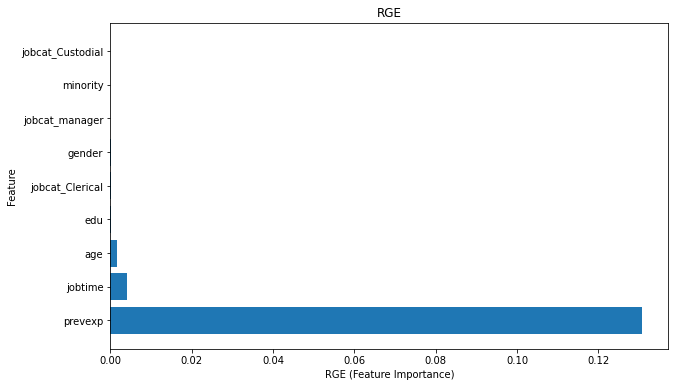

,RGE
prevexp,0.130697
jobtime,0.003968
age,0.001621
edu,0.000180
jobcat_Clerical,0.000018
gender,0.000013
jobcat_manager,0.000011
minority,0.000009
jobcat_Custodial,0.000005


In [18]:
check_explainability.rge(xtrain, xtest, ytrain, ytest, ann_full)

# ROBUSTNESS

In [19]:
check_robustness.rgr(xtrain, xtest, ytrain, ytest, ann_full, perturbationtimes=2)

,RGR
age,1.000000
edu,1.000000
jobtime,1.000000
prevexp,0.999999
minority,0.999999
gender,0.999999
jobcat_Clerical,0.999999
jobcat_Custodial,0.999999
jobcat_manager,0.999999


# FAIRNESS

In [20]:
check_fairness.rgf(xtrain, xtest, ytrain, ytest, ["gender"],ann_full)

,RGF
gender,0.999987


# PRIVACY

In [21]:
check_privacy.rgs(xtrain, xtest, ytrain, ytest, ann_full)

,RGS
0,0.000000e+00
1,0.000000e+00
2,0.000000e+00
3,0.000000e+00
4,0.000000e+00
5,0.000000e+00
6,0.000000e+00
7,0.000000e+00
8,0.000000e+00
9,0.000000e+00
